In [15]:
import numpy as np
from qiskit import *
from qiskit import Aer
import pandas as pd
from qiskit.test.mock import *
from qiskit.providers.aer.noise.noise_model import NoiseModel
from qiskit.providers.aer import AerSimulator, QasmSimulator
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
import itertools
import mitiq
import cma
from qiskit.tools.monitor import job_monitor
import random
import re
%matplotlib inline

In [26]:
L = 3

# def TwirledCNOT(circ, qb0, qb1):
#     def apply_pauli(circ, num, qb):
#         if (num == 0):
#             circ.i(qb)
#         elif (num == 1):
#             circ.x(qb)
#         elif (num == 2):
#             circ.y(qb)
#         else:
#             circ.z(qb)
#         return circ
        
#     paulis = [(i,j) for i in range(0,4) for j in range(0,4)]
#     paulis.remove((0,0))
#     paulis_map = [(0, 1), (3, 2), (3, 3), (1, 1), (1, 0), (2, 3), (2, 2), (2, 1), (2, 0), (1, 3), (1, 2), (3, 0), (3, 1), (0, 2), (0, 3)]
#     num = random.randrange(len(paulis))

#     apply_pauli(circ, paulis[num][0], qb0)
#     apply_pauli(circ, paulis[num][1], qb1)
#     circ.cnot(qb0, qb1)
#     apply_pauli(circ, paulis_map[num][0], qb0)
#     apply_pauli(circ, paulis_map[num][1], qb1)
#     return circ

def TwirlCircuit(circ):
    def apply_pauli(num, qb):
        if (num == 0):
            return f'id q[{qb}];\n'
        elif (num == 1):
            return f'x q[{qb}];\n'
        elif (num == 2):
            return f'y q[{qb}];\n'
        else:
            return f'z q[{qb}];\n'

    paulis = [(i,j) for i in range(0,4) for j in range(0,4)]
    paulis.remove((0,0))
    paulis_map = [(0, 1), (3, 2), (3, 3), (1, 1), (1, 0), (2, 3), (2, 2), (2, 1), (2, 0), (1, 3), (1, 2), (3, 0), (3, 1), (0, 2), (0, 3)]

    new_circ = ''
    ops = circ.qasm().splitlines(True)
    for op in ops:
        if (op[:2] == 'cx'): # can add for cz, etc.
            num = random.randrange(len(paulis))
            qbs = re.findall('q\[(.)\]', op)
            new_circ += apply_pauli(paulis[num][0], qbs[0])
            new_circ += apply_pauli(paulis[num][1], qbs[1])
            new_circ += op
            new_circ += apply_pauli(paulis_map[num][0], qbs[0])
            new_circ += apply_pauli(paulis_map[num][1], qbs[1])
        else:
            new_circ += op
    return qiskit.circuit.QuantumCircuit.from_qasm_str(new_circ)

def TrotterEvolveCircuit(dt, nt, init):
    """
    Implements trotter evolution of the Heisenberg hamiltonian using the circuit from https://arxiv.org/pdf/1906.06343.pdf
    :param tf: time to evolve to
    :param nt: number of trotter steps to use
    :param init: initial state for the trotter evolution. Should be another Qiskit circuit
    """

    # def get_angles(a, b, c):
    #     return (np.pi/2 - 2*c, 2*a - np.pi/2, np.pi/2 - 2*b)
    def get_angles(a):
        return (np.pi/2 - 2*a, 2*a - np.pi/2, np.pi/2 - 2*a)

    def N(cir, qb0, qb1):
        cir.rz(-np.pi/2, qb1)
        cir.cnot(qb1, qb0)
        cir.rz(theta, qb0)
        cir.ry(phi, qb1)
        cir.cnot(qb0, qb1)
        cir.ry(lambd, qb1)
        cir.cnot(qb1, qb0)
        cir.rz(np.pi/2, qb0)
        return cir

    theta, phi, lambd = get_angles(-dt/4)
    circ = init

    for i in range(nt):
        # even (odd indices)
        if (L % 2 == 0):
            # UEven
            for i in range(1, L-1, 2): # L for periodic bdy conditions
                circ = N(circ, i, (i+1)%L)
            # UOdd
            for i in range(0, L-1, 2):
                circ = N(circ, i, (i+1)%L)
        else:
            # UEven
            for i in range(1, L, 2):
                circ = N(circ, i, (i+1)%L)
            # UOdd
            for i in range(0, L-1, 2):
                circ = N(circ, i, (i+1)%L)
            # UBdy
            # circ = N(circ, L-1, 0)
    
    return circ

def AnsatzCircuit(params, p):
    """
    Implements HVA ansatz using circuits from https://arxiv.org/pdf/1906.06343.pdf
    :param params: parameters to parameterize circuit
    :param p: depth of the ansatz
    """
    circ = QuantumCircuit(L)

    def get_angles(a):
        return (np.pi/2 - 2*a, 2*a - np.pi/2, np.pi/2 - 2*a)

    def N(cir, angles, qb0, qb1):
        cir.rz(-np.pi/2, qb1)
        cir.cnot(qb1, qb0)
        cir.rz(angles[0], qb0)
        cir.ry(angles[1], qb1)
        cir.cnot(qb0, qb1)
        cir.ry(angles[2], qb1)
        cir.cnot(qb1, qb0)
        cir.rz(np.pi/2, qb0)
        return cir

    for i in range(p):
        if (L % 2 == 0):
            for j in range(1, L-1, 2): # L for periodic bdy conditions
                circ = N(circ, get_angles(-params[((L-1)*i)+j]/4), j, (j+1)%L)
            for j in range(0, L-1, 2):
                circ = N(circ, get_angles(-params[((L-1)*i)+j]/4), j, (j+1)%L)
        else:
            for j in range(1, L, 2):
                circ = N(circ, get_angles(-params[((L-1)*i)+j]/4), j, (j+1)%L)
            for j in range(0, L-1, 2):
                circ = N(circ, get_angles(-params[((L-1)*i)+j]/4), j, (j+1)%L)
            # circ = N(circ, get_angles(-params[(L*i)+L-1]/4), L-1, 0) # boundary
    return circ

def ReorderBasis(circ):
    """
    Reorders basis so that 0th qubit is on the left side of the tensor product
    :param circ: circuit to reorder, can also be a vector
    """
    if (isinstance(circ, qiskit.circuit.quantumcircuit.QuantumCircuit)):
        for i in range(L//2):
            circ.swap(i, L-i-1)
        return circ
    else:
        perm = np.eye(2**L)
        for i in range(1, 2**L//2):
            perm[:, [i, 2**L-i-1]] = perm[:, [2**L-i-1, i]]
        return perm @ circ

def SimulateAndReorder(circ):
    """
    Executes a circuit using the statevector simulator and reorders basis to match with standard
    """
    circ = ReorderBasis(circ)
    backend = Aer.get_backend('statevector_simulator')
    return execute(circ, backend).result().get_statevector()

def Simulate(circ):
    """
    Executes a circuit using the statevector simulator. Doesn't reorder -- which is needed for intermediate steps in the VTC
    """
    backend = Aer.get_backend('statevector_simulator')
    return execute(circ, backend).result().get_statevector()

def SwapTestCircuit(params, U_v, U_trot, init, p):
    """
    Cost function using the swap test. 
    :param params: parameters new variational circuit that represents U_trot U_v | init >. Need dagger for cost function
    :param U_v: variational circuit that stores the state before the trotter step
    :param U_trot: trotter step
    :param init: initial state
    :param p: number of ansatz steps
    :param shots: number of measurements to take
    """
    U_v_prime = init + AnsatzCircuit(params, p)
    U_v_prime = U_v_prime.qasm()
    U_v_prime = U_v_prime.replace(f'q[{L}]', f'q[{2*L+1}]')

    for i in range(L, -1, -1):
        U_v_prime = U_v_prime.replace(f'q[{i}]', f'q[{i+1}]')
    U_v_prime = qiskit.circuit.QuantumCircuit.from_qasm_str(U_v_prime)

    comp = init + U_v + U_trot
    comp = comp.qasm()
    comp = comp.replace(f'q[{L}]', f'q[{2*L+1}]')
    for i in range(L, -1, -1):
        comp = comp.replace(f'q[{i}]', f'q[{L+i+1}]')
    comp = qiskit.circuit.QuantumCircuit.from_qasm_str(comp)

    circ = QuantumCircuit(2*L+1, 1)
    circ.h(0)
    circ += U_v_prime 
    circ += comp

    # controlled swaps
    for i in range(L):
        circ.cswap(0, i+1, L+i+1)
    circ.h(0)
    circ.measure(0,0)

    return circ

def SwapTestExecutor(circuits, backend, shots, filter):
    scale_factors = [1.0, 1.5, 2.0]
    folded_circuits = []
    for circuit in circuits:
        folded_circuits.append([mitiq.zne.scaling.fold_gates_at_random(circuit, scale) for scale in scale_factors])
    folded_circuits = list(itertools.chain(*folded_circuits))

    job = qiskit.execute(
        experiments=folded_circuits,
        backend=backend,
        optimization_level=0,
        shots=shots
    )

    res = job.result()
    if (filter is not None):
        res = filter.apply(res)

    all_counts = [job.result().get_counts(i) for i in range(len(folded_circuits))]
    expectation_values = []
    for counts in all_counts:
        if counts.get('0') is None:
            expectation_values.append(0)
        else:
            expectation_values.append(counts.get('0')/shots)
    
    zero_noise_values = []
    if isinstance(backend, qiskit.providers.aer.backends.qasm_simulator.QasmSimulator): # exact_sim
        for i in range(len(circuits)):
            zero_noise_values.append(np.mean(expectation_values[i*len(scale_factors):(i+1)*len(scale_factors)]))
    else: #device_sim
        fac = mitiq.zne.inference.PolyFactory(scale_factors, 2)
        for i in range(len(circuits)):
            zero_noise_values.append(fac.extrapolate(scale_factors, 
            expectation_values[i*len(scale_factors):(i+1)*len(scale_factors)]), order=2)

    return zero_noise_values
 
def SwapTest(params, U_v, U_trot, init, p, backend, shots, filter):
    """

    """
    circs = []
    for param in params:
        circs.append(SwapTestCircuit(param, U_v, U_trot, init, p))
    res = SwapTestExecutor(circs, backend, shots, filter)
    return 1 - np.array(res)

def LoschmidtEchoExecutor(circuits, backend, shots, filter):
    """
    Returns the expectation value to be mitigated.
    :param circuit: Circuit to run.
    :param backend: backend to run the circuit  on
    :param shots: Number of times to execute the circuit to compute the expectation value.
    :param fitter: measurement error mitigator
    """
    # circuits = [TwirlCircuit(circ) for circ in circuits]
    scale_factors = [1.0, 1.5, 2.0]
    folded_circuits = []
    for circuit in circuits:
        folded_circuits.append([mitiq.zne.scaling.fold_gates_at_random(circuit, scale) for scale in scale_factors])
    folded_circuits = list(itertools.chain(*folded_circuits))
    folded_circuits = [TwirlCircuit(circ) for circ in folded_circuits]


    job = qiskit.execute(
        experiments=folded_circuits,
        backend=backend,
        optimization_level=0,
        shots=shots
    )

    # job_monitor(job)

    c = c = ['1', '1', '0'] #[str((1 + (-1)**(i+1)) // 2) for i in range(L)]
    c = ''.join(c)[::-1]
    res = job.result()
    if (filter is not None):
        res = filter.apply(res)

    all_counts = [job.result().get_counts(i) for i in range(len(folded_circuits))]
    expectation_values = []
    for counts in all_counts:
        total_allowed_shots = [counts.get(''.join(p)) for p in set(itertools.permutations(c))]
        total_allowed_shots = sum([0 if x is None else x for x in total_allowed_shots])
        if counts.get(c) is None:
            expectation_values.append(0)
        else:
            expectation_values.append(counts.get(c)/total_allowed_shots)
    print(expectation_values)
    # expectation_values = [counts.get(c) / shots for counts in all_counts]
    
    zero_noise_values = []
    if isinstance(backend, qiskit.providers.aer.backends.qasm_simulator.QasmSimulator): # exact_sim
        for i in range(len(circuits)):
            zero_noise_values.append(np.mean(expectation_values[i*len(scale_factors):(i+1)*len(scale_factors)]))
    else: #device_sim
        fac = mitiq.zne.inference.LinearFactory(scale_factors=scale_factors)
        for i in range(len(circuits)):
            zero_noise_values.append(fac.extrapolate(scale_factors, 
            expectation_values[i*len(scale_factors):(i+1)*len(scale_factors)]))
    print(zero_noise_values)
    return zero_noise_values

def LoschmidtEchoCircuit(params, U_v, U_trot, init, p):
    """
    Cost function using the Loschmidt Echo. Just using statevectors currently -- can rewrite using shots
    :param params: parameters new variational circuit that represents U_trot U_v | init >. Need dagger for cost function
    :param U_v: variational circuit that stores the state before the trotter step
    :param U_trot: trotter step
    :param init: initial state
    :param p: number of ansatz steps
    """
    U_v_prime = AnsatzCircuit(params, p)
    circ = init + U_v + U_trot + U_v_prime.inverse()
    circ.measure_all()
    return circ

def LoschmidtEcho(params, U_v, U_trot, init, p, backend, shots, filter):
    """

    """
    circs = []
    for param in params:
        circs.append(LoschmidtEchoCircuit(param, U_v, U_trot, init, p))
    res = LoschmidtEchoExecutor(circs, backend, shots, filter)
    return 1 - np.array(res)

def LoschmidtEchoExact(params, U_v, U_trot, init, p):
    U_v_prime = AnsatzCircuit(params, p)
    circ = init + U_v + U_trot + U_v_prime.inverse()

    circ_vec = Simulate(circ)
    init_vec = Simulate(init)
    return 1 - abs(np.conj(circ_vec) @ init_vec)**2

def CMAES(U_v, U_trot, init, p, backend, shots, filter):
    init_params = np.random.uniform(0, 2*np.pi, (L-1)*p)
    es = cma.CMAEvolutionStrategy(init_params, np.pi/2)
    es.opts.set({'ftarget':1e-11, 'maxiter':100}) #ftarget
    while not es.stop():
        solutions = es.ask()
        es.tell(solutions, LoschmidtEcho(solutions, U_v, U_trot, init, p, backend, shots, filter))
        es.disp()
    return es.result_pretty()

def VTC(tf, dt, p, init):
    """
    :param init: initial state as a circuit
    """
    nt = int(np.ceil(tf / (dt * p)))

    VTCParamList = []
    VTCStepList = [SimulateAndReorder(init.copy())]
    TrotterFixStepList = [init]
    TimeStep = [0]

    for i in range(nt):
        print(i, nt)
        if (i == 0):
            U_v = QuantumCircuit(L)
        else:
            U_v = AnsatzCircuit(VTCParamList[-1], p)
        U_trot = TrotterEvolveCircuit(dt, p, QuantumCircuit(L))
        
        TrotterFixStepList.append(TrotterFixStepList[-1] + U_trot)
        
        init_params = np.random.uniform(0, np.pi, (L-1)*p)
        # res = minimize(fun=SwapTest, x0=init_params, args=(U_v, U_trot, init, p, 8192), method='COBYLA')
        # res = minimize(fun=LoschmidtEcho, x0=init_params, args=(U_v, U_trot, init, p, exact_sim, 8192, None), method='COBYLA')
        # res = minimize(fun=LoschmidtEchoExact, x0=init_params, args=(U_v, U_trot, init, p))
        # res = [0, 1]
        # while (res[1] > 0.05):
        res = CMAES(U_v, U_trot, init, p, device_sim, 8192, meas_fitter.filter)

        print(res)
        
        VTCParamList.append(res[0]) #res.x
        VTCStepList.append(SimulateAndReorder(init + AnsatzCircuit(res[0], p))) #res.x
        TimeStep.append(TimeStep[-1]+(dt*p))
    
    TrotterFixStepList = pd.DataFrame(np.array([SimulateAndReorder(c.copy()) for c in TrotterFixStepList]), index=np.array(TimeStep))
    VTCParamList = pd.DataFrame(np.array(VTCParamList), index=np.array(TimeStep[1:]))
    VTCStepList = pd.DataFrame(np.array(VTCStepList), index=np.array(TimeStep))

    VTCStepList.to_csv(f'./VTD_results/VTD_results_{tf}_{L}_{p}_{dt}.csv')


In [4]:
L = 3
p = 2

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-research-2', group='iowa-state-uni-2', project='main')

qr = QuantumRegister(L)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')

device_backend = FakeSantiago()
device_sim = AerSimulator.from_backend(device_backend)
exact_sim = Aer.get_backend('qasm_simulator')
sim = device_sim

# Execute the calibration circuits without noise
t_qc = transpile(meas_calibs, sim)
qobj = assemble(t_qc, shots=10000)
cal_results = sim.run(qobj, shots=10000).result()
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
# np.around(meas_fitter.cal_matrix, decimals=2)

real_device = provider.get_backend('ibmq_santiago')

In [5]:
init_params = np.random.uniform(0, 2*np.pi, (L-1)*p)

init = QuantumCircuit(L)
c = ['1', '1', '0'] # [str((1 + (-1)**(i+1)) // 2) for i in range(L)]
for q in range(len(c)):
    if (c[q] == '1'):
        init.x(q)

U_v = QuantumCircuit(L)
U_trot = TrotterEvolveCircuit(1, 2, QuantumCircuit(L))

In [63]:
# U_v = AnsatzCircuit(np.array([2.0425250870377347,6.496045992178892,-3.1434331369484294,8.755874601633497]), p)
U_v = QuantumCircuit(L)
U_trot = TrotterEvolveCircuit(1, 2, QuantumCircuit(L))

es = cma.CMAEvolutionStrategy(init_params, np.pi/2) #, {'ftarget':5e-3})
for i in range(1):
    solutions = [[2.3610684458146465,4.037883694765664,4.398823533374377,2.51527396005402]]*7
    # print(repr(solutions))
    LoschmidtEcho(solutions, U_v, U_trot, init, p, real_device, 8192, meas_fitter.filter)
    # es.logger.add()
    # es.disp()

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=672487, Sat Jul 17 18:35:10 2021)
[0.76, 0.7391304347826086, 0.49153488372093024, 0.7740792109724148, 0.7091973244147157, 0.4067508957194041, 0.7137141942710834, 0.6890275611024441, 0.5762773063729915, 0.7616196628328344, 0.6748065348237318, 0.665279536819251, 0.7665999075643198, 0.6435962680237489, 0.5943877551020408, 0.6536630317923514, 0.5678500630744279, 0.647354694485842, 0.7904451682953312, 0.6182579564489112, 0.5886899151743638]
[1.0662527805864506, 1.1810016165816937, 0.8658283524293104, 0.84507876717898, 0.9265128722567878, 0.632418435743971, 0.9684305596543193]


In [23]:
# U_v = AnsatzCircuit(np.array([2.0425250870377347,6.496045992178892,-3.1434331369484294,8.755874601633497]), p)
U_v = QuantumCircuit(L)
U_trot = TrotterEvolveCircuit(1, 2, QuantumCircuit(L))

es = cma.CMAEvolutionStrategy(init_params, np.pi/2) #, {'ftarget':5e-3})
for i in range(1):
    solutions = [[3.0299502213336282,-0.1565913376801552,2.8895391809675965,1.4030828553396069]]
    LoschmidtEcho(solutions, U_v, U_trot, init, p, device_sim, 81920, meas_fitter.filter)
    # es.logger.add()
    # es.disp()

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=745001, Mon Jul 19 14:22:20 2021)
[0.6757267441860465, 0.6484777482389342, 0.6327164327412744]
[0.7168224422225763]


In [22]:
# U_v = AnsatzCircuit(np.array([2.0425250870377347,6.496045992178892,-3.1434331369484294,8.755874601633497]), p)
U_v = QuantumCircuit(L)
U_trot = TrotterEvolveCircuit(1, 2, QuantumCircuit(L))

es = cma.CMAEvolutionStrategy(init_params, np.pi/2) #, {'ftarget':5e-3})
for i in range(1):
    solutions = [[3.0299502213336282,-0.1565913376801552,2.8895391809675965,1.4030828553396069]]
    LoschmidtEcho(solutions, U_v, U_trot, init, p, exact_sim, 81920, None)
    # es.logger.add()
    # es.disp()

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=808123, Mon Jul 19 14:22:10 2021)
[0.71346435546875, 0.7134521484375, 0.71513671875]
[0.7140177408854166]


In [32]:
p = 1
U_v = AnsatzCircuit(np.array([2.0425250870377347,6.496045992178892]), p)
U_trot = TrotterEvolveCircuit(1, 2, QuantumCircuit(L))
cir = LoschmidtEchoCircuit([2.0425250870377347,6.49604599217889], U_v, U_trot, init, p)
cir.qasm().count('cx')

24

In [33]:
p = 1
U_v = AnsatzCircuit(np.array([2.0425250870377347,6.496045992178892]), p)
U_trot = TrotterEvolveCircuit(1, 2, QuantumCircuit(L))
cir = SwapTestCircuit([2.0425250870377347,6.49604599217889], U_v, U_trot, init, p)
U_v.qasm().count('cx')

6

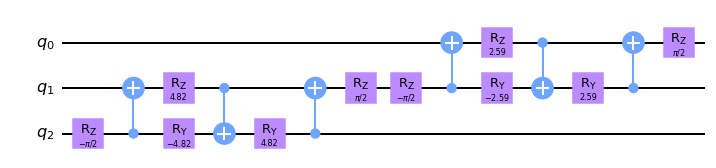

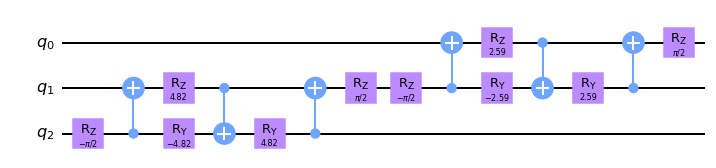

In [35]:
U_v.draw(output='mpl')